In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from matplotlib import pyplot as plt
import cv2 # for image pre-processing
import gc
from tqdm import tqdm
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.applications import DenseNet121,DenseNet169,DenseNet201

In [2]:
# loading the dataset
train_df = pd.read_csv('train.csv')

In [3]:
# top 5 rows of dataset
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


<Axes: ylabel='Frequency'>

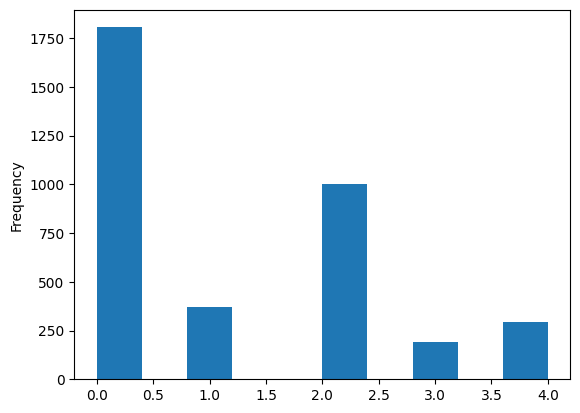

In [4]:
# distribution of classes in dataset ( which is imbalanced )
train_df['diagnosis'].plot(kind='hist')

In [5]:
# dimension of csv train file
train_df.shape

(3662, 2)

In [6]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # RGB to Grayscale
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

### Preprocessing the Image :

In [7]:
def preprocess_image(image_path, desired_size=256):
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
   # im = crop_image_from_gray(im)
    im = cv2.resize(im,(desired_size,)*2)
    res = cv2.addWeighted(im,4.5,cv2.GaussianBlur( im , (0,0) , 10) ,-4 ,100)
    return res

def preprocess_image1(image_path, desired_size=256):
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    im = crop_image_from_gray(im)
    im = cv2.resize(im,(desired_size,)*2)
    res = cv2.addWeighted(im,4.5,cv2.GaussianBlur( im , (0,0) , 10) ,-4 ,100)
    return res

In [8]:
N1 = train_df.shape[0]
x_train1 = np.empty((N1, 256, 256, 3), dtype=np.uint8)
#tqdm
for i, image_id in tqdm(enumerate((train_df['id_code']))):
    x_train1[i, :, :, :] = preprocess_image1(
        f'train_images/{image_id}.png'
    )    

3662it [07:32,  8.10it/s]


In [9]:
y_train = pd.get_dummies(train_df['diagnosis']).values

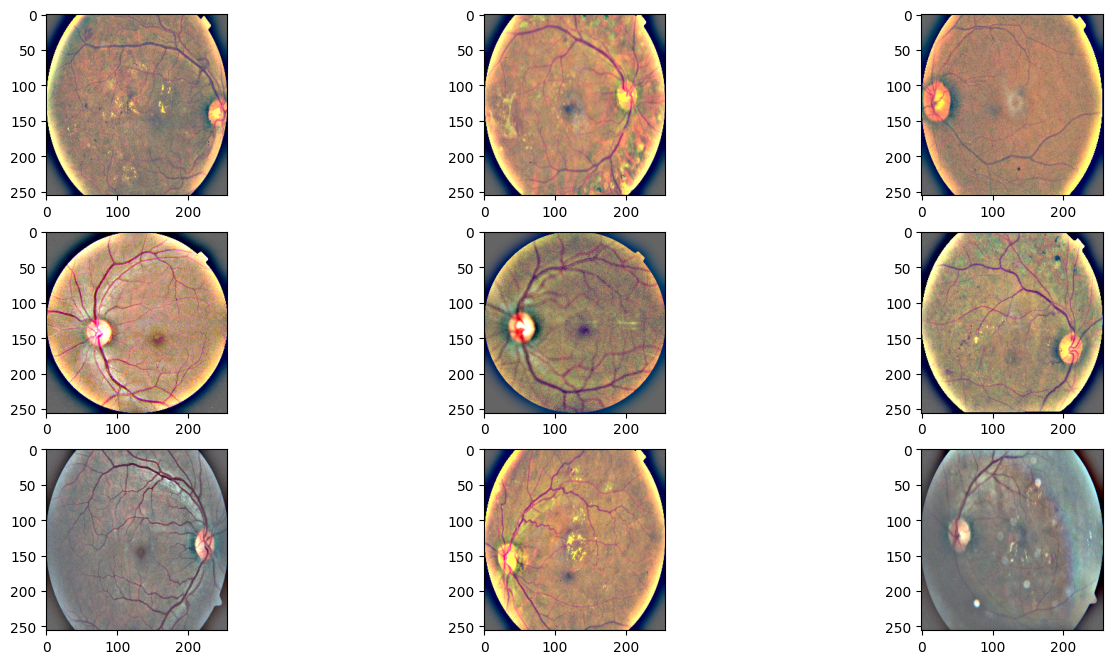

In [10]:
plt.figure(figsize=(16,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train1[i])

In [11]:
del N1
gc.collect()

23012

In [12]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1805  370  999  193  295]
Multilabel version: [3662 1857 1487  488  295]


In [13]:
np.save('y_train1.npy',y_train_multi)
np.save('x_train1.npy',x_train1)

In [14]:
x_train1 = np.load('x_train1.npy')
y_train1 = np.load('y_train1.npy')

In [15]:
from sklearn.model_selection import train_test_split
x_sptrain, x_spval, y_sptrain, y_spval = train_test_split(
    x_train1, y_train1, 
    random_state=42
)
print("train-validation splitted ...")

train-validation splitted ...


In [16]:
# Find the lengths of the arrays
len_x_sptrain = len(x_sptrain)
len_x_spval = len(x_spval)
len_y_sptrain = len(y_sptrain)
len_y_spval = len(y_spval)

# Print the lengths
print("Length of x_sptrain:", len_x_sptrain)
print("Length of x_spval:", len_x_spval)
print("Length of y_sptrain:", len_y_sptrain)
print("Length of y_spval:", len_y_spval)


Length of x_sptrain: 2746
Length of x_spval: 916
Length of y_sptrain: 2746
Length of y_spval: 916


In [17]:
del x_train1,y_train1
gc.collect()

0

In [18]:
from keras.preprocessing.image import ImageDataGenerator
def create_datagen():
    return ImageDataGenerator(
        horizontal_flip=True,   # randomly flip images
        vertical_flip=True,     # randomly flip images
        rotation_range=20 ,      # Degree range for random rotations
        zoom_range=0.1
    )

# Using original generator
data_generator = create_datagen().flow(x_sptrain, y_sptrain,batch_size=16,seed=20031976)
print("Image data augmentated ...")

Image data augmentated ...


In [19]:
import tensorflow as tf
import keras.backend as K
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [20]:
gc.collect()

0

In [21]:
effnet = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(256,256,3)
)

2023-11-23 19:00:02.455557: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-23 19:00:02.455961: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-23 19:00:02.456802: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-23 19:00:02.457245: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-23 19:00:02.457747: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
model = Sequential()
model.add(effnet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))

model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy',f1],
)

In [23]:
gc.collect()


13979

In [24]:
from keras.callbacks import Callback,ModelCheckpoint
from sklearn.metrics import cohen_kappa_score
import json
class KappaMetrics(Callback):
    i=0
    def on_train_begin(self, logs={}):
        self.val_kappas = []
        
    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"Epoch: {epoch+1} val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model. - "+str(KappaMetrics.i))
            model_json = self.model.to_json()
            with open("model_in_json"+str(KappaMetrics.i)+".json", "w") as json_file:
                json.dump(model_json, json_file)
            self.model.save_weights("model_weights"+str(KappaMetrics.i)+".h5")
            KappaMetrics.i+=1
        return
    
kappa_score = KappaMetrics()

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.metrics import F1Score

with tf.keras.utils.custom_object_scope({
    'F1Score': F1Score
}):
    history = model.fit(
        data_generator,  # Your data generator
        steps_per_epoch=92,  # Number of batches per epoch
        epochs=8,
        validation_data=(x_spval, y_spval),
        verbose=1,
        callbacks=[EarlyStopping(patience=5)],
    )

Epoch 1/8


2023-11-23 19:00:13.237183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-11-23 19:00:14.915253: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


92/92 [==============================] - 215s 2s/step - loss: 0.3103 - accuracy: 0.9905 - f1: 0.5797 - val_loss: 3470.6660 - val_accuracy: 1.0000 - val_f1: 0.2000
Epoch 2/8
92/92 [==============================] - 150s 2s/step - loss: 0.2066 - accuracy: 0.9959 - f1: 0.6142 - val_loss: 48.8573 - val_accuracy: 1.0000 - val_f1: 0.2000
Epoch 3/8
92/92 [==============================] - 219s 2s/step - loss: 0.2737 - accuracy: 0.9809 - f1: 0.6071 - val_loss: 3.2748 - val_accuracy: 1.0000 - val_f1: 0.3823
Epoch 4/8
92/92 [==============================] - 198s 2s/step - loss: 0.2688 - accuracy: 0.9625 - f1: 0.5972 - val_loss: 0.5637 - val_accuracy: 0.9989 - val_f1: 0.5282
Epoch 5/8
92/92 [==============================] - 301s 3s/step - loss: 0.1793 - accuracy: 0.9543 - f1: 0.6394 - val_loss: 0.1881 - val_accuracy: 0.9945 - val_f1: 0.5707
Epoch 6/8
92/92 [==============================] - 389s 4s/step - loss: 0.1721 - accuracy: 0.9735 - f1: 0.6662 - val_loss: 0.2614 - val_accuracy: 1.0000 - v

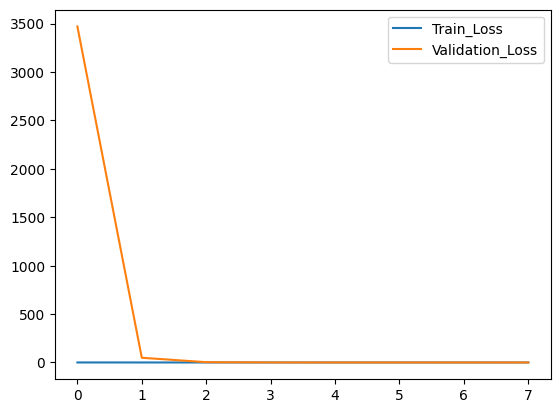

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train_Loss','Validation_Loss'])

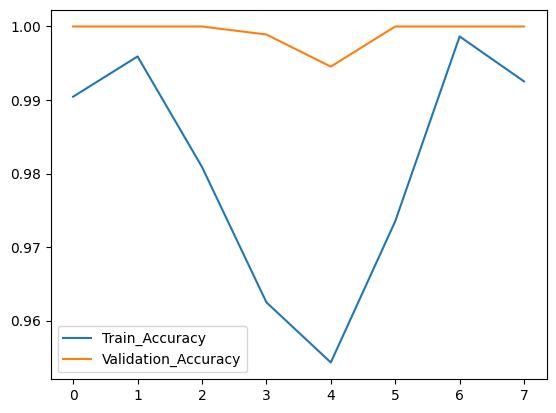

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train_Accuracy','Validation_Accuracy'])

In [28]:
model.save('full_model.h5')

/Users/atharva/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 6s 6s/step


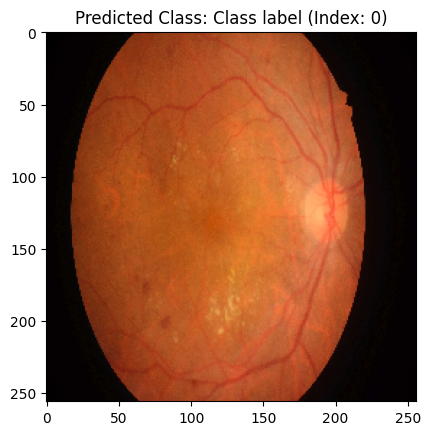

In [33]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the model with custom metric
model = load_model('full_model.h5', custom_objects={'f1': f1})

img_path = '/Users/atharva/Desktop/A. Segmentation/1. Original Images/a. Training Set/IDRiD_01.jpg'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(256, 256))  # Adjust target_size based on your model input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize pixel values to be between 0 and 1, assuming your training data was also normalized

# Get model predictions
predictions = model.predict(img_array)

# Assuming you have a classification model
class_index = np.argmax(predictions)
class_label = 'Class label'  # Replace with your actual class labels

# Display the image
plt.imshow(img)
plt.title(f'Predicted Class: {class_label} (Index: {class_index})')
plt.show()
